In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [12]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [13]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"])
df["quarter"] = df.Date.dt.quarter
df = pd.get_dummies(df, columns=["quarter"])
df.set_index("Date", inplace=True)
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,1,0,0,0
1981-01-02,17.9,1,0,0,0
1981-01-03,18.8,1,0,0,0
1981-01-04,14.6,1,0,0,0
1981-01-05,15.8,1,0,0,0


# Scalling membantu RNN

In [11]:
df.Temp = df.Temp.transform(lambda x: (x-x.mean())/x.std())

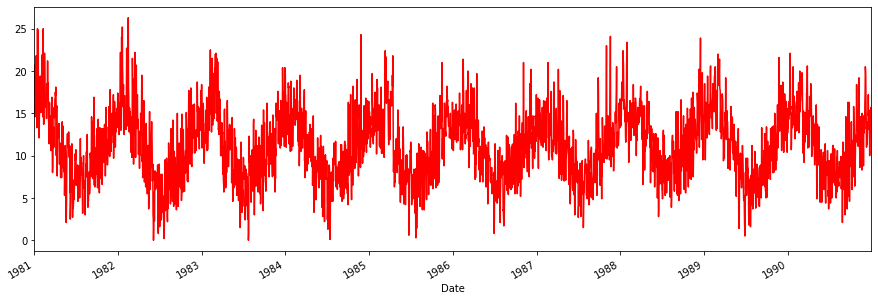

In [14]:
 df.Temp.plot(figsize=(15,5), color="r")

# Dataset Splitting

In [15]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 5), (730, 5))

# Dataset & Dataloader

In [16]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [35]:
seq_len = 7
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)


(N, S, F): (417, 7, 5)
Note: last 0 data excluded

(N, S, F): (104, 7, 5)
Note: last 1 data excluded



# Arsitektur & Config

In [36]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [38]:
config = set_config({
    "input_size" : train_set.n_feature,
    "seq_len" : train_set.n_seq,
    "output_size" : 1, 
    "hidden_size" : 128, 
    "num_layers"  : 3,
    "dropout"     : 0.2
})

# Training Preparation -> MCOC

In [39]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/multivar")

# Training

In [40]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 97.8111 | Test_cost  = 52.7514 | 




Epoch     2
Train_cost  = 36.6559 | Test_cost  = 27.7597 | 




Epoch     3
Train_cost  = 21.3472 | Test_cost  = 19.1867 | 




Epoch     4
Train_cost  = 16.8611 | Test_cost  = 16.9409 | 




Epoch     5
Train_cost  = 16.1117 | Test_cost  = 16.5851 | 




Epoch     6
Train_cost  = 16.1444 | Test_cost  = 16.5473 | 




Epoch     7
Train_cost  = 16.1233 | Test_cost  = 16.5309 | 




Epoch     8
Train_cost  = 16.0865 | Test_cost  = 16.5171 | 




Epoch     9
Train_cost  = 16.0308 | Test_cost  = 16.5013 | 




Epoch    10
Train_cost  = 16.0055 | Test_cost  = 16.4811 | 




Epoch    11
Train_cost  = 15.9698 | Test_cost  = 16.4575 | 




Epoch    12
Train_cost  = 15.9446 | Test_cost  = 16.4343 | 




Epoch    13
Train_cost  = 15.9192 | Test_cost  = 16.4118 | 




Epoch    14
Train_cost  = 15.8590 | Test_cost  = 16.3896 | 




Epoch    15
Train_cost  = 15.8525 | Test_cost  = 16.3694 | 




Epoch    16
Train_cost  = 15.8128 | Test_cost  = 16.3502 | 




Epoch    17
Train_cost  = 15.7840 | Test_cost  = 16.3310 | 




Epoch    18
Train_cost  = 15.7694 | Test_cost  = 16.3117 | 




Epoch    19
Train_cost  = 15.7536 | Test_cost  = 16.2906 | 




Epoch    20
Train_cost  = 15.7000 | Test_cost  = 16.2625 | 


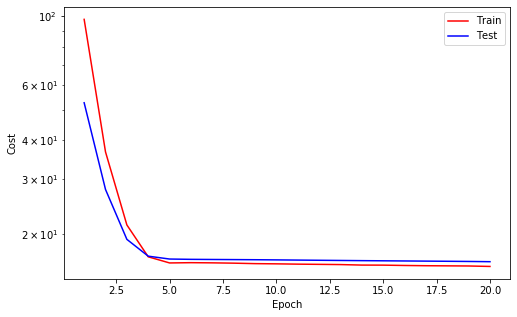



Epoch    21
Train_cost  = 15.6479 | Test_cost  = 16.1986 | 




Epoch    22
Train_cost  = 15.5082 | Test_cost  = 15.9952 | 




Epoch    23
Train_cost  = 14.8458 | Test_cost  = 13.0147 | 




Epoch    24
Train_cost  = 11.9199 | Test_cost  = 10.9158 | 




Epoch    25
Train_cost  = 10.0704 | Test_cost  = 9.5118 | 




Epoch    26
Train_cost  = 8.9819 | Test_cost  = 8.4203 | 




Epoch    27
Train_cost  = 8.4929 | Test_cost  = 7.5520 | 




Epoch    28
Train_cost  = 8.0007 | Test_cost  = 7.0656 | 




Epoch    29
Train_cost  = 7.7379 | Test_cost  = 6.7802 | 




Epoch    30
Train_cost  = 7.4733 | Test_cost  = 6.6164 | 




Epoch    31
Train_cost  = 7.3334 | Test_cost  = 6.4145 | 




Epoch    32
Train_cost  = 7.1996 | Test_cost  = 6.2889 | 




Epoch    33
Train_cost  = 7.0984 | Test_cost  = 6.1951 | 




Epoch    34
Train_cost  = 7.0098 | Test_cost  = 6.1100 | 




Epoch    35
Train_cost  = 6.9544 | Test_cost  = 6.0388 | 




Epoch    36
Train_cost  = 6.8182 | Test_cost  = 5.9696 | 




Epoch    37
Train_cost  = 6.8439 | Test_cost  = 5.9591 | 




Epoch    38
Train_cost  = 6.7990 | Test_cost  = 5.8668 | 




Epoch    39
Train_cost  = 6.6731 | Test_cost  = 5.7814 | 




Epoch    40
Train_cost  = 6.6536 | Test_cost  = 5.7757 | 


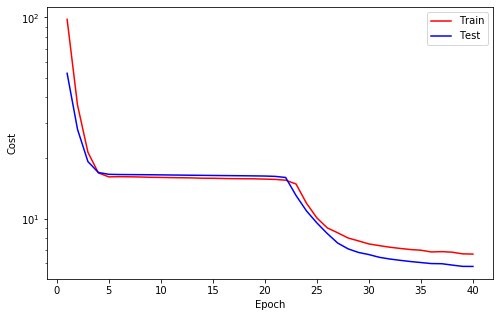



Epoch    41
Train_cost  = 6.6827 | Test_cost  = 5.7807 | 
==> EarlyStop patience =  1 | Best test_cost: 5.7757




Epoch    42
Train_cost  = 6.6569 | Test_cost  = 5.7900 | 
==> EarlyStop patience =  2 | Best test_cost: 5.7757




Epoch    43
Train_cost  = 6.7101 | Test_cost  = 5.7464 | 




Epoch    44
Train_cost  = 6.6863 | Test_cost  = 5.7192 | 




Epoch    45
Train_cost  = 6.6388 | Test_cost  = 5.6626 | 




Epoch    46
Train_cost  = 6.6042 | Test_cost  = 5.5984 | 




Epoch    47
Train_cost  = 6.6468 | Test_cost  = 5.6159 | 
==> EarlyStop patience =  1 | Best test_cost: 5.5984




Epoch    48
Train_cost  = 6.6267 | Test_cost  = 5.5434 | 




Epoch    49
Train_cost  = 6.6652 | Test_cost  = 5.4704 | 




Epoch    50
Train_cost  = 6.6245 | Test_cost  = 5.4606 | 




Epoch    51
Train_cost  = 6.6521 | Test_cost  = 5.4540 | 




Epoch    52
Train_cost  = 6.6759 | Test_cost  = 5.4002 | 




Epoch    53
Train_cost  = 6.6409 | Test_cost  = 5.4750 | 
==> EarlyStop patience =  1 | Best test_cost: 5.4002




Epoch    54
Train_cost  = 6.4731 | Test_cost  = 5.4478 | 
==> EarlyStop patience =  2 | Best test_cost: 5.4002




Epoch    55
Train_cost  = 6.3903 | Test_cost  = 5.3789 | 




Epoch    56
Train_cost  = 6.3650 | Test_cost  = 5.3404 | 




Epoch    57
Train_cost  = 6.2890 | Test_cost  = 5.3130 | 




Epoch    58
Train_cost  = 6.3349 | Test_cost  = 5.2855 | 




Epoch    59
Train_cost  = 6.3832 | Test_cost  = 5.3427 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2855




Epoch    60
Train_cost  = 6.3182 | Test_cost  = 5.2909 | 


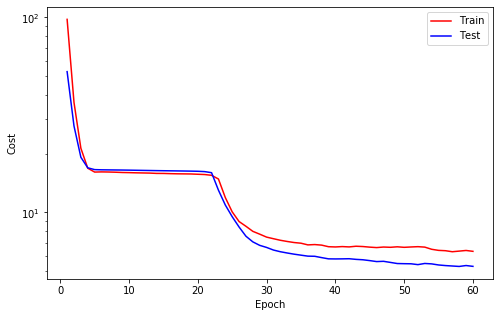

==> EarlyStop patience =  2 | Best test_cost: 5.2855




Epoch    61
Train_cost  = 6.3355 | Test_cost  = 5.2843 | 




Epoch    62
Train_cost  = 6.3134 | Test_cost  = 5.2810 | 




Epoch    63
Train_cost  = 6.3595 | Test_cost  = 5.3043 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2810




Epoch    64
Train_cost  = 6.3147 | Test_cost  = 5.2769 | 




Epoch    65
Train_cost  = 6.2549 | Test_cost  = 5.2999 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2769




Epoch    66
Train_cost  = 6.1839 | Test_cost  = 5.3181 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2769




Epoch    67
Train_cost  = 6.1470 | Test_cost  = 5.2543 | 




Epoch    68
Train_cost  = 6.2390 | Test_cost  = 5.2730 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2543




Epoch    69
Train_cost  = 6.1528 | Test_cost  = 5.3203 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2543




Epoch    70
Train_cost  = 6.1068 | Test_cost  = 5.2267 | 




Epoch    71
Train_cost  = 6.1235 | Test_cost  = 5.2581 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2267




Epoch    72
Train_cost  = 6.2050 | Test_cost  = 5.2605 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2267




Epoch    73
Train_cost  = 6.3559 | Test_cost  = 5.2426 | 
==> EarlyStop patience =  3 | Best test_cost: 5.2267




Epoch    74
Train_cost  = 6.1982 | Test_cost  = 5.2577 | 
==> EarlyStop patience =  4 | Best test_cost: 5.2267




Epoch    75
Train_cost  = 6.1731 | Test_cost  = 5.2261 | 




Epoch    76
Train_cost  = 6.1203 | Test_cost  = 5.2120 | 




Epoch    77
Train_cost  = 6.1653 | Test_cost  = 5.2794 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2120




Epoch    78
Train_cost  = 5.9968 | Test_cost  = 5.2284 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2120




Epoch    79
Train_cost  = 6.0433 | Test_cost  = 5.2027 | 




Epoch    80
Train_cost  = 6.0412 | Test_cost  = 5.2056 | 


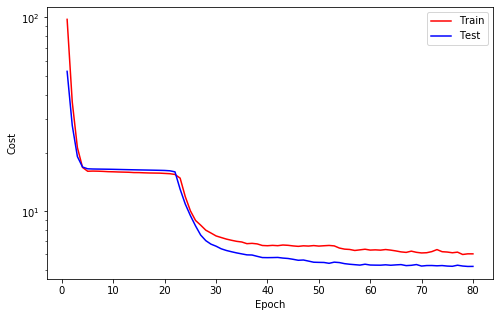

==> EarlyStop patience =  1 | Best test_cost: 5.2027




Epoch    81
Train_cost  = 6.1479 | Test_cost  = 5.2072 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2027




Epoch    82
Train_cost  = 6.0256 | Test_cost  = 5.2117 | 
==> EarlyStop patience =  3 | Best test_cost: 5.2027




Epoch    83
Train_cost  = 5.9971 | Test_cost  = 5.2515 | 
==> EarlyStop patience =  4 | Best test_cost: 5.2027




Epoch    84
Train_cost  = 6.0009 | Test_cost  = 5.1735 | 




Epoch    85
Train_cost  = 6.0701 | Test_cost  = 5.1923 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1735




Epoch    86
Train_cost  = 6.0528 | Test_cost  = 5.2392 | 
==> EarlyStop patience =  2 | Best test_cost: 5.1735




Epoch    87
Train_cost  = 6.0946 | Test_cost  = 5.2115 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1735




Epoch    88
Train_cost  = 5.9323 | Test_cost  = 5.2186 | 
==> EarlyStop patience =  4 | Best test_cost: 5.1735




Epoch    89
Train_cost  = 5.9258 | Test_cost  = 5.2203 | 
==> EarlyStop patience =  5 | Best test_cost: 5.1735
==> Execute Early Stopping at epoch: 89 | Best test_cost: 5.1735
==> Best model is saved at model/multivar


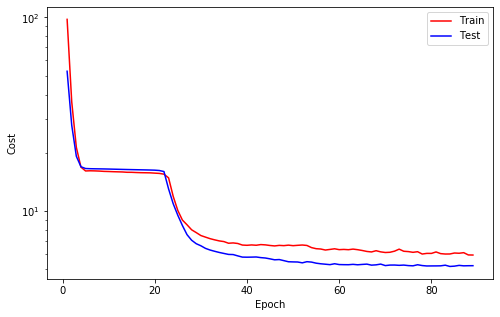

In [41]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [42]:
from luwiji.rnn import illustration

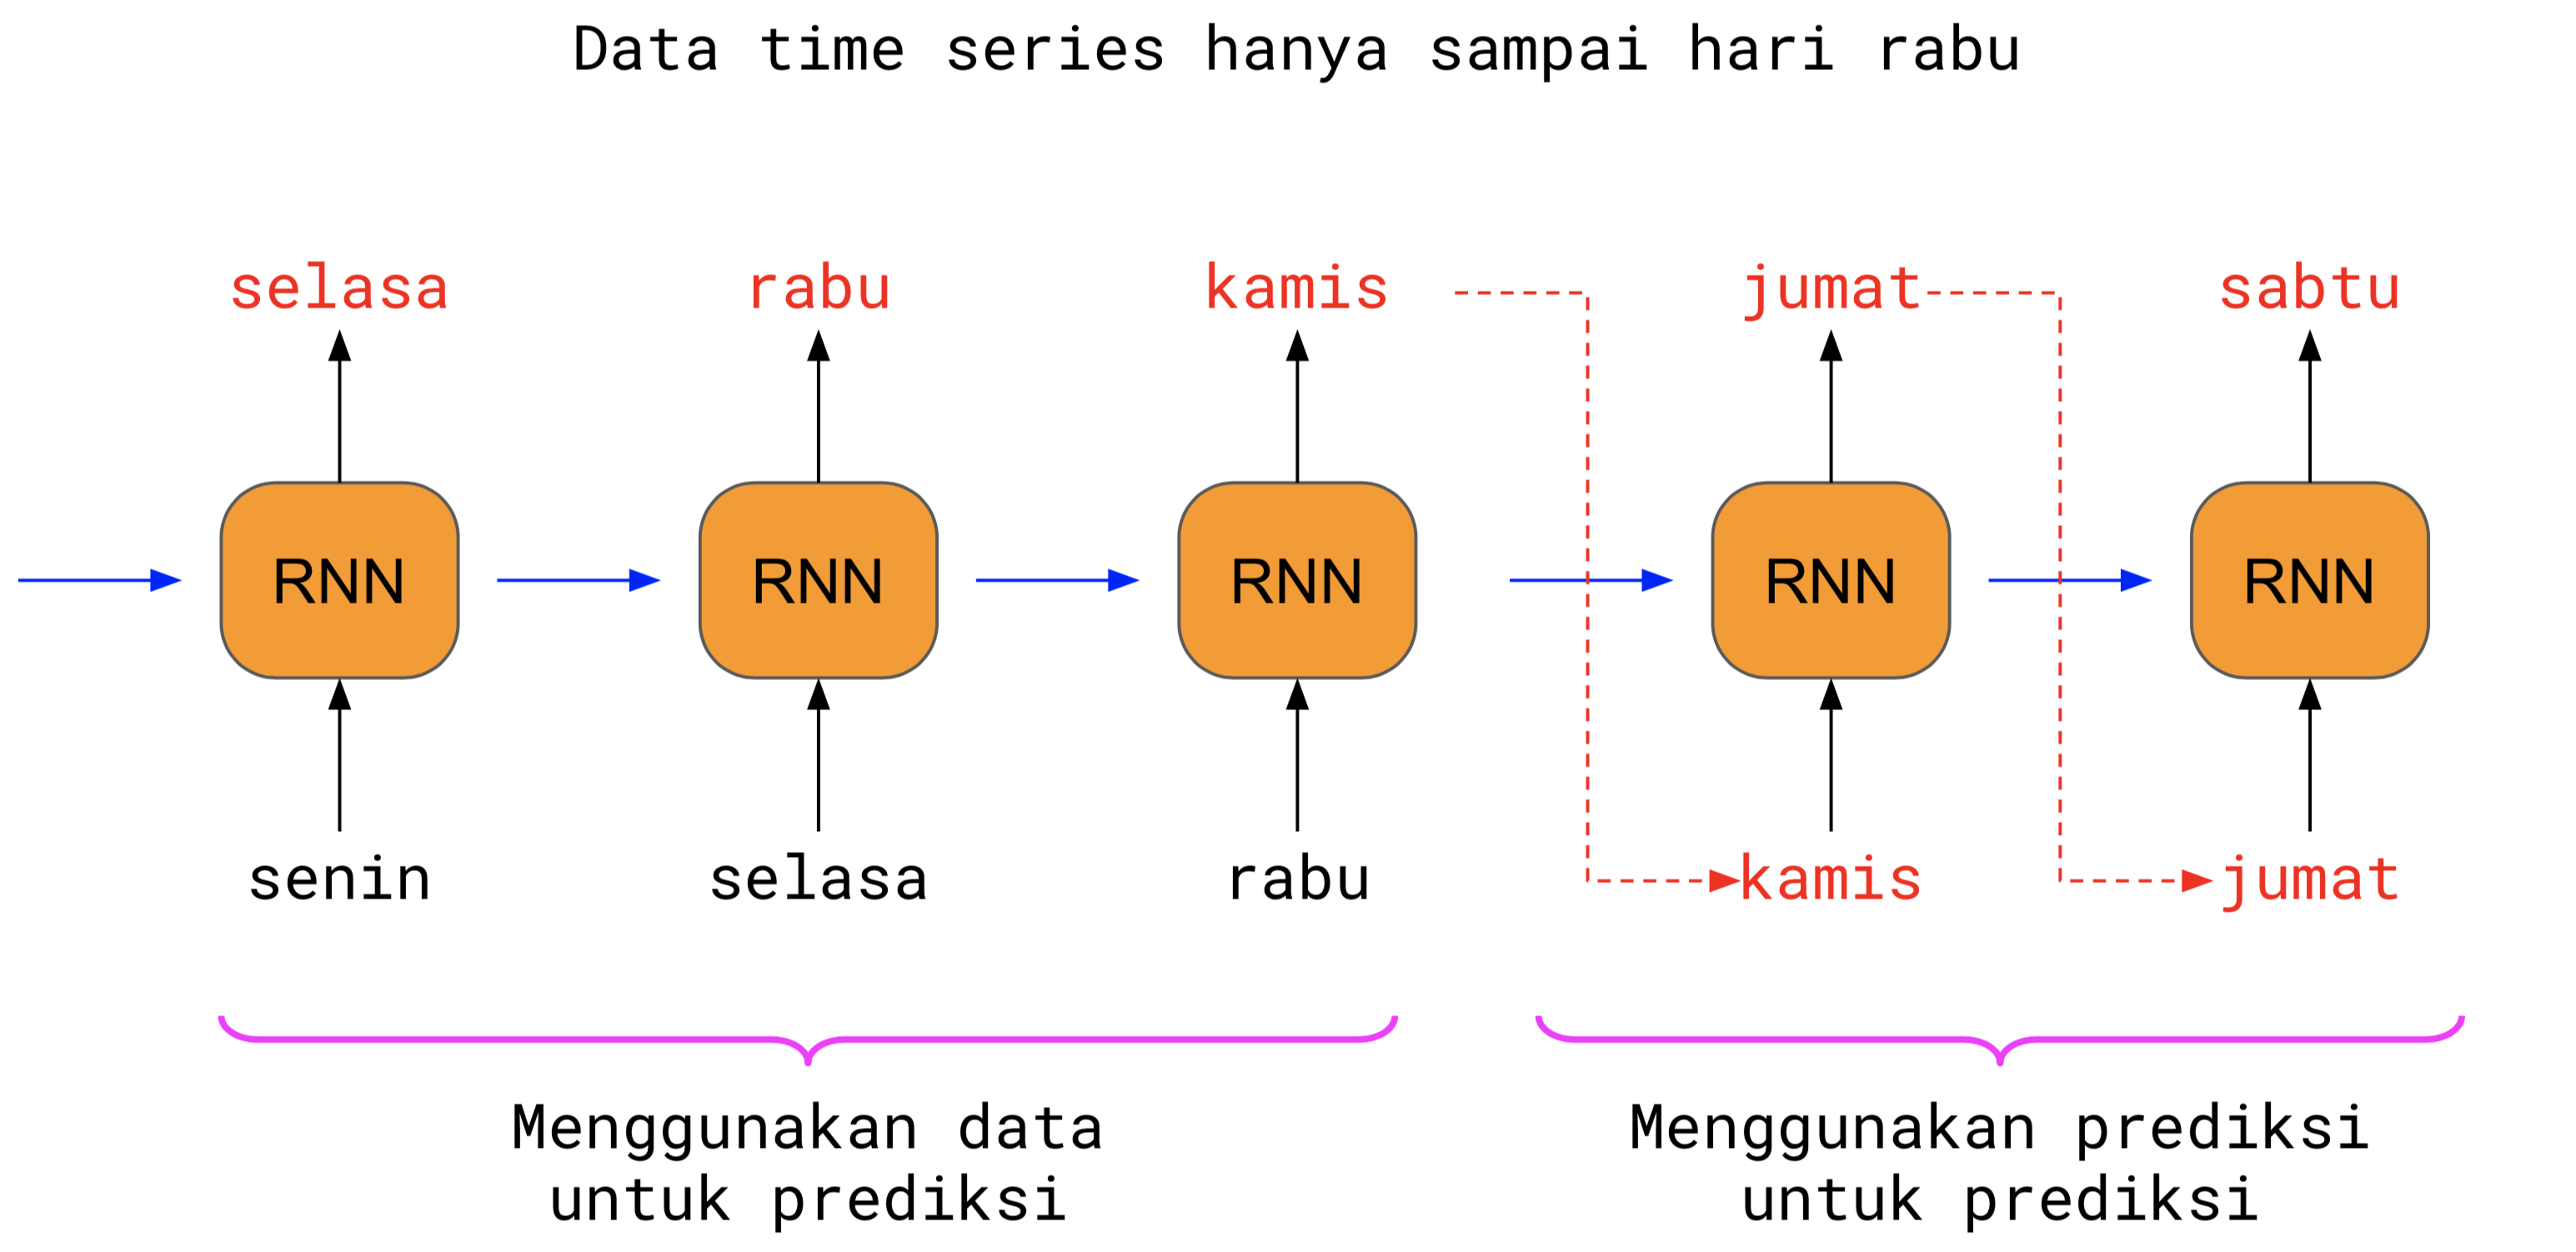

In [43]:
illustration.forecast

In [44]:
from utils import data4pred, pred4pred

In [45]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 5)
Note: last 0 data excluded

(N, S, F): (729, 1, 5)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

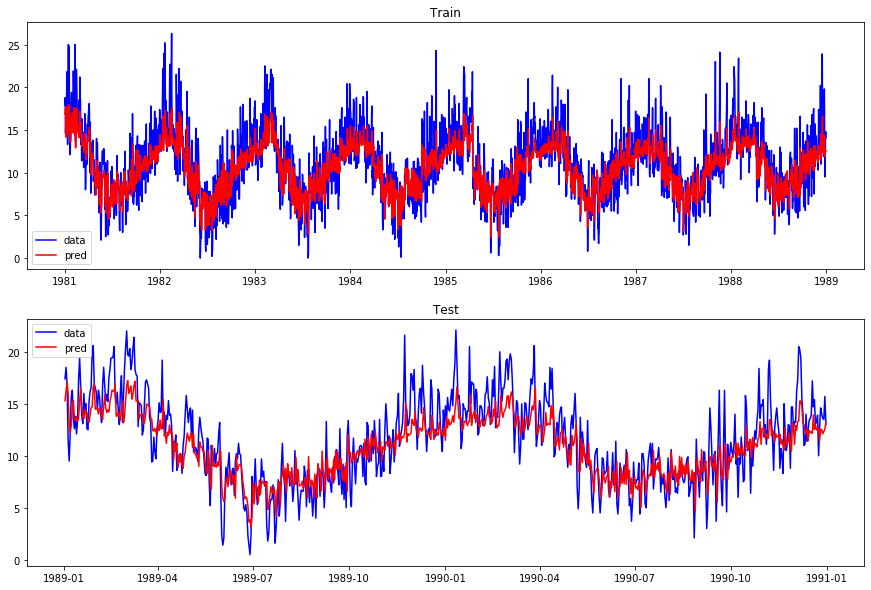

In [46]:
# Data 4 Pred
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

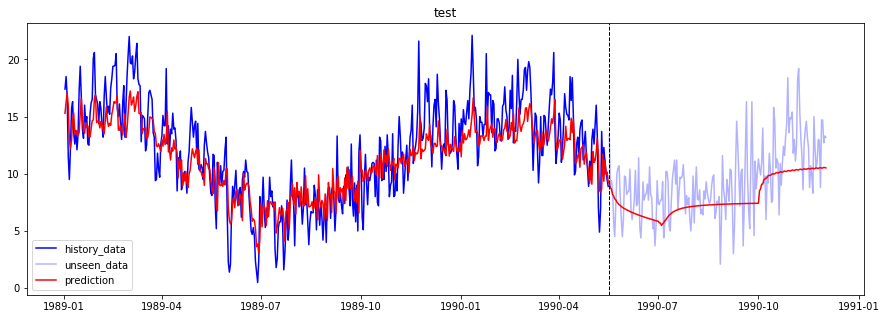

In [47]:
# Pred 4 Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")

# More on RNN

In [48]:
from luwiji.rnn import illustration

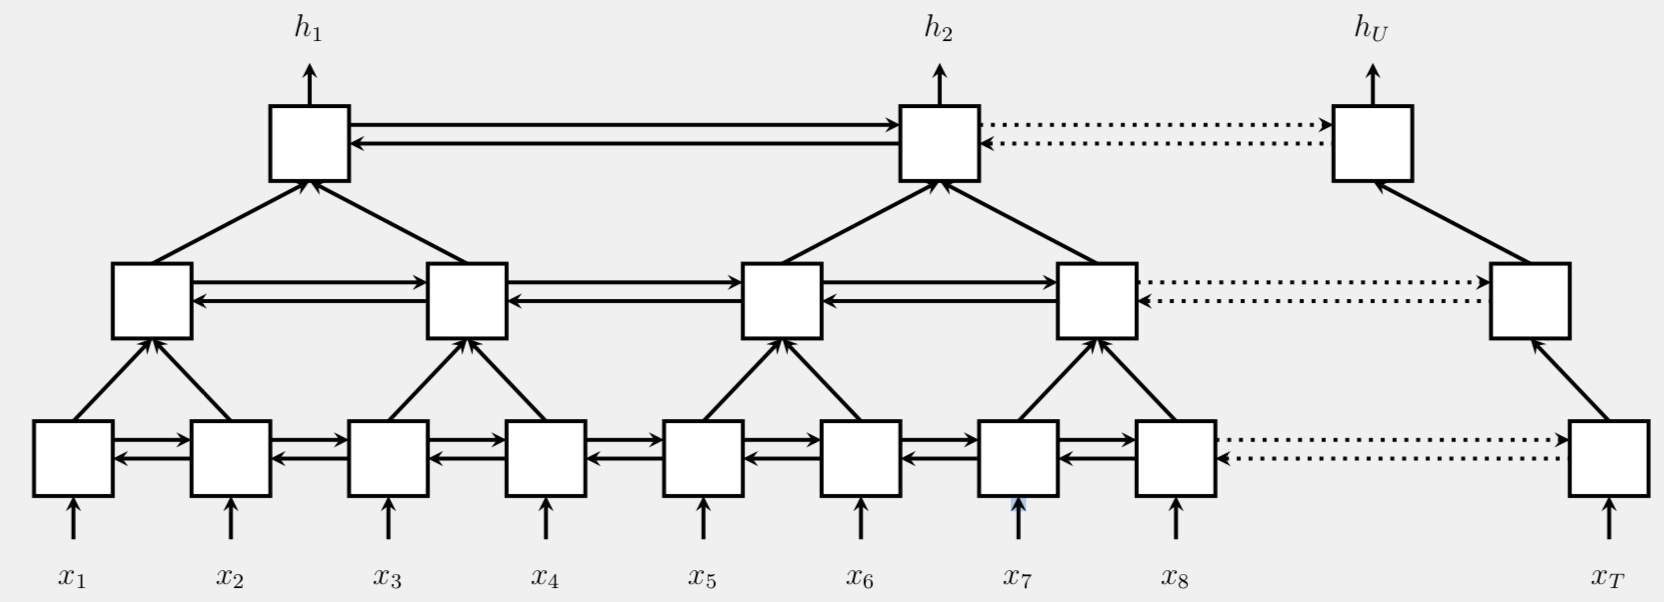

In [49]:
illustration.pyramid_blstm

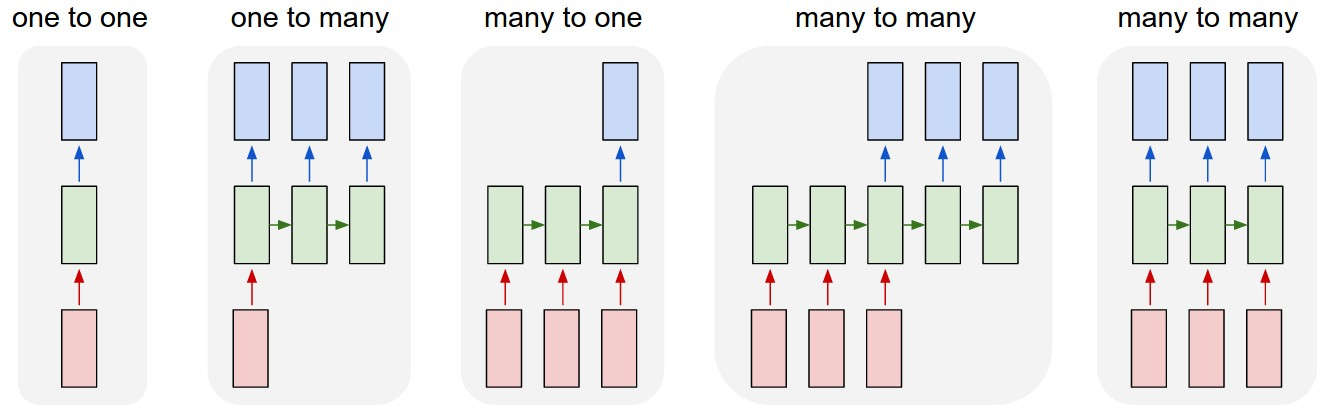

In [50]:
illustration.sequence_model

* one to one (fixed input and output)
    - Image classification

* one to many (fixed input and sequence output)
    - Image captioning

* many to one (sequence input and fixed output)
    - sentiment analysis

* many to many (seqeunce input and sequence output)
    - machine translation

* synced many to many (sequence input and sequence output)
    - frame level video classification

Please check this out
http://karpathy.github.io/2015/05/21/rnn-effectiveness/

RNN Midi Composer 
https://www.youtube.com/watch?v=0eTYs4n1LKg&t=2s